<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/close_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Small python script that plots the difference between close and open prices of s&p stocks

In [160]:
# Installation
!pip install yfinance
!pip install yahoo_fin --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
import random

## Hyper parameters
history = "5y"
buy_trigger = 3                           # times standard deviation
sell_trigger = 1                          # times the avg cost of the security to grow before we sell
security_age = 15                         # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000                # times the orignal amount to grow before we lockin the gains.
mean_type = "+ve"                         # only consider stocks with +ve mean of ND. These stocks have been growing over the period of time
max_stocks_to_buy = 5                     # number of stocks to buy at buy trigger. We can change this value to be more adaptive based on market cap of the security and other parameters.
backtest_iterations = 25                   # number of backtests to run
backtest_days = random.sample(range(100, 400), backtest_iterations) # starting days for back testing
backtest_days.sort()
prefer_beta = True

starting_balance = 10000                  # seed money to start investing
current_account = original_balance = starting_balance
portfolio = {}

# Display test results
print_final_portfolio = False              # Prints the portfolio list at the end of each backtest iteration
plot_every_test_graph = True              # Prints the model performance during the back end against s&P500
plot_summary_graph = True                  # prints the summary graph

In [162]:
tests = [
    {
        "Name": "Test 1",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1000,
        "prefer_beta": True
     },
     {
        "Name": "Test 2",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True
     },
     {
        "Name": "Test 3",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True
     },
     {
        "Name": "Test 4",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": False
     },
     {
        "Name": "Test 5",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True
     },
]

tests_to_run = [3,4,5]

In [163]:
import yfinance as yahooFinance
import yahoo_fin.stock_info as si
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
import pprint

pp = pprint.PrettyPrinter(indent=4)

stocks = si.tickers_sp500()
indices = ['^IXIC', '^GSPC', '^DJI']
stocks_ts = pd.DataFrame()
stocks_spread = pd.DataFrame()
indices_ts = pd.DataFrame()

for idx in indices:
    data = yahooFinance.Ticker(idx).history(period=history)
    d = data.copy()[['Open', 'Close']]
    indices_ts[idx+"_Open"] = d['Open']
    indices_ts[idx+"_Close"] = d['Close']

betas = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/betas.csv")
betas = betas.drop(['index', 'Attribute', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1)
betas = betas.rename(columns={"Recent": "Beta"})
betas = betas.set_index('Ticker')
for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period=history)
    d = data.copy()[['Open', 'Close']]
    stocks_ts[stock+"_Open"] = d['Open']
    stocks_ts[stock+"_Close"] = d['Close']
    stocks_spread[stock] = (d['Close'] - d['Open']) * 100/d['Open']

    stocks_ts = stocks_ts.copy()
    stocks_spread = stocks_spread.copy()


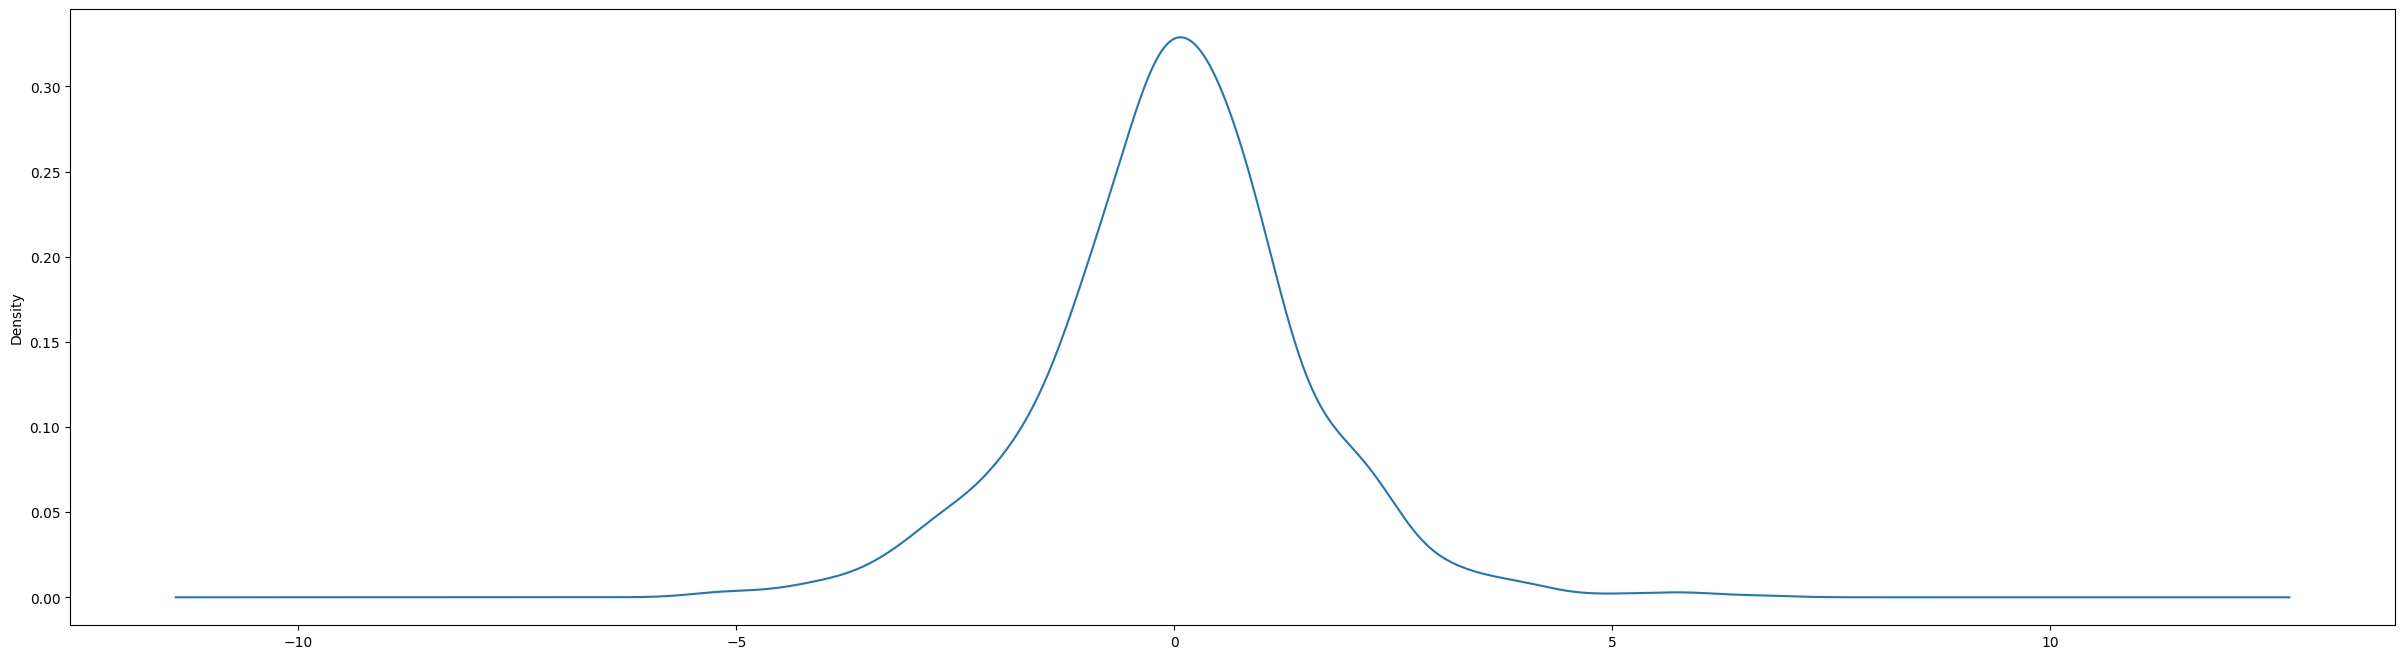

In [164]:

for stock in stocks[:1]:
    #latest[stock] = data.iloc[-1]['Close'] - data.iloc[-1]['Open']

    fig = go.Figure(data=[go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['Open'],
                low=d['Close'],
                close=d['Close'])])
    fig.update_layout(
      title=stock,
      yaxis_title=stock +' Stock',
      shapes = [dict(
          x0='2022-12-09', x1='2022-12-09', y0=0, y1=1, xref='x', yref='paper',
          line_width=2)],
      annotations=[dict(
          x='2022-12-09', y=0.05, xref='x', yref='paper',
          showarrow=False, xanchor='left', text='Increase Period Begins')]
    )

    fig.show()

    stocks_spread['Date'] = stocks_spread.index
    fig = px.line(stocks_spread, x="Date", y=stock, title="Stocks Daily Price change", markers=True) 
    fig.show()

    x = pd.Series(stocks_spread[stock])
    ax = x.plot.kde(figsize=(30,8))
    #sns.set(rc={'figure.figsize':(25.7,8.27)})
    #sns.lineplot(x="Date",y=stock, data=stocks_spread, markers=True, err_style="bars")
    #sns.despine();

In [165]:
#print(stocks_spread.describe())
std = stocks_spread.describe().loc['std']
mean = stocks_spread.describe().loc['mean']
std = pd.DataFrame.from_dict(std)
std.columns = ['std',]

mean = pd.DataFrame.from_dict(mean)
mean.columns = ['mean',]

fig = px.line(std, title="Daily Stock Price change", markers=True)
fig.show()


In [166]:
# Determine what stocks are in buy zone and what stocks are in sell zone
# Start date of the investing

def getsellbuy(index, portfolio):
  latest = {}
  for s in stocks:
      latest[s] = (stocks_ts.loc[index][s+"_Close"] - stocks_ts.loc[index][s+"_Open"])* 100 /stocks_ts.loc[index][s+"_Open"]

  latest = pd.Series(latest)
  pd.DataFrame.from_dict(latest)
  latest_diff = pd.DataFrame.from_dict(latest)
  latest_diff.columns = ['diff',]
  #latest_diff = latest_diff.iloc[::-1]

  latest_diff['std'] = std['std']

  # Find stocks that are in buy range
  latest_diff['buy'] = np.where(((mean_type != "+ve" or mean['mean'] > 0) & (latest_diff['diff'] < 0) & (latest_diff['diff'] < -buy_trigger * std['std'])), True, False)
  latest_diff['beta'] = betas['Beta']

  # Find stocks that are in sell range
  latest_diff['sell'] = False #np.where((latest_diff['diff'] >= std['std']), True, False)
  for s in stocks:
    if s in portfolio:
      t = index - portfolio[s]['date']
      avg = sum(portfolio[s]['costs'])/len(portfolio[s]['costs'])
      if avg + sell_trigger * std['std'][s] * avg / 100 <= stocks_ts.loc[index, s+"_Close"]:
        # If the avg cost of the security has grown more than std
        #print(s, avg, portfolio[s]['costs'], std['std'][s+"_Diff"], stocks_ts.loc[index, s+"_Close"])
        latest_diff.at[s, 'sell'] = True
      elif t.days > security_age:
        # if the security has aged for certain days, cut the losses
        latest_diff.at[s, 'sell'] = True
  
  # Print which stocks are buy and which are sell
  #print("Stock to Buy on " + str(index))
  #print(latest_diff[latest_diff['buy']])
  #print()
  #print("Stocks to Sell on " + str(index))
  #print(latest_diff[latest_diff['sell']])
  sell_stocks = latest_diff[latest_diff['sell']]
  buy_stocks = latest_diff[latest_diff['buy']]
  if prefer_beta:
    buy_stocks = buy_stocks.sort_values('beta',ascending=False)
  return sell_stocks, buy_stocks


In [167]:
# We assume that we invest $100 in each stock that is in the buy zone
# and sell all stocks in the sell zone

# We will start back testing from year back. We can always change the starting point and tune the model.

def calculate_networth(backtest_start_date):
  networth = current_account
  for stock, value in portfolio.items():
    networth += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
  return networth

def do_one_backtesting(tradingdays_togoback):
  global portfolio
  global original_balance
  global current_account

  original_balance = starting_balance
  current_account = original_balance
  portfolio = {}

  idx = int(len(stocks_ts.index)- tradingdays_togoback)
  price_movement = []
  cash_inhand = []
  for backtest_start_date in stocks_ts.index[idx:]:
      sell, buy = getsellbuy(backtest_start_date, portfolio)

      # process the stocks that are marked sell
      for st in sell.iterrows():
        stock = st[0].split('_')[0]
        if stock in portfolio:
          current_account += portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio.pop(stock)
      
      # buy stocks that are marked by. We are buying max_stocks_to_buy number of stocks
      # TODO: The number of stocks to be must be adaptive. Will come up with some
      # algorithm based on:
      # 1. Market capitalization
      # 2. Beta
      # and other criteria
      # The goal is to put the money to work
      for st in buy.iterrows():
        stock = st[0].split('_')[0]
        if current_account > max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]:
          current_account -= max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          if not stock in portfolio:
              assert portfolio.get(stock, None) == None
              portfolio[stock] = {'shares': 0, 'costs':[], 'date': backtest_start_date}
          portfolio[stock]['shares'] += max_stocks_to_buy
          for i in range(max_stocks_to_buy):
            portfolio[stock]['costs'].append(stocks_ts.loc[backtest_start_date][stock+"_Close"])

      # lock in the gains after 10% increase of networth
      nw = calculate_networth(backtest_start_date)
      price_movement.append(nw)
      cash_inhand.append(current_account)
      if nw > original_balance * lockin_gains_factor:
          #print(backtest_start_date, calculate_networth(backtest_start_date), current_account, portfolio)
          for stock, value in portfolio.items():
            current_account += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio = {}
          original_balance = current_account
          #print(current_account, portfolio)
      #print(current_account, portfolio)
  return calculate_networth(backtest_start_date), current_account, price_movement, cash_inhand

In [168]:

def run_backtest():
  nws = {}
  sp_ret = {}
  for i in backtest_days:
    tradingdays_togoback = i
    networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
    # normalize s&p500 for starting balance
    idx_list = list(indices_ts.loc[indices_ts.index[-tradingdays_togoback:], "^GSPC_Close"] * starting_balance/indices_ts.loc[indices_ts.index[-tradingdays_togoback], "^GSPC_Close"])
    pm_pct = (pm[-1]-pm[0])*100/pm[0]
    d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list, "Cash_In_Hand": cih})
    d.index = indices_ts.index[-tradingdays_togoback:]
    idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
    print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
    print("Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct))
    if print_final_portfolio:
      pp.pprint(portfolio)
    nws[i] = networth
    sp_ret[i] = idx_list[-1]
    if plot_every_test_graph:
      fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct), markers=True)
      fig.show()

  if plot_summary_graph:
    plt.plot(nws.keys(), nws.values(), color="green")
    plt.plot(sp_ret.keys(), sp_ret.values(), color="blue")
    plt.title("Networth at the end of each iteration")
    plt.xlabel('Days') 
    plt.ylabel('Networth')
    plt.legend()
    plt.show()
    print(sum(nws.values())/len(nws))

Test Parameters for Test 3
{   'Name': 'Test 3',
    'buy_trigger': 2,
    'lockin_gains_factor': 1.1,
    'prefer_beta': True,
    'security_age': 1000,
    'sell_trigger': 1}
Total networth: 11418 (Cash 860) after going back 101
Model (14.186547)% vs S&P Performance (8.984366)%


Total networth: 11138 (Cash 982) after going back 107
Model (11.386680)% vs S&P Performance (7.932393)%


Total networth: 12579 (Cash 2566) after going back 131
Model (25.790081)% vs S&P Performance (11.266021)%


Total networth: 11476 (Cash 4639) after going back 160
Model (14.761159)% vs S&P Performance (-3.991445)%


Total networth: 11037 (Cash 969) after going back 164
Model (10.379138)% vs S&P Performance (-0.742743)%


Total networth: 11480 (Cash 4643) after going back 166
Model (14.808637)% vs S&P Performance (-1.026746)%


Total networth: 12710 (Cash 4604) after going back 189
Model (27.104705)% vs S&P Performance (7.423673)%


Total networth: 12383 (Cash 2592) after going back 194
Model (23.830738)% vs S&P Performance (5.050695)%


Total networth: 13836 (Cash 4477) after going back 217
Model (38.361583)% vs S&P Performance (5.330191)%


Total networth: 12652 (Cash 4651) after going back 223
Model (26.524407)% vs S&P Performance (4.560466)%


Total networth: 11683 (Cash 1166) after going back 228
Model (16.835334)% vs S&P Performance (-0.905745)%


Total networth: 11967 (Cash 4888) after going back 237
Model (19.678876)% vs S&P Performance (-3.803326)%


Total networth: 11362 (Cash 334) after going back 262
Model (13.629531)% vs S&P Performance (-6.853637)%


Total networth: 11198 (Cash 192) after going back 283
Model (11.988536)% vs S&P Performance (-8.091123)%


Total networth: 11213 (Cash 160) after going back 291
Model (12.132858)% vs S&P Performance (-8.221883)%


Total networth: 10355 (Cash 222) after going back 294
Model (3.559825)% vs S&P Performance (-8.996463)%


Total networth: 8780 (Cash 49) after going back 303
Model (-12.198056)% vs S&P Performance (-10.220419)%


Total networth: 11315 (Cash 5044) after going back 342
Model (13.155336)% vs S&P Performance (-12.529905)%


Total networth: 11530 (Cash 4463) after going back 344
Model (15.301922)% vs S&P Performance (-12.356593)%


Total networth: 11669 (Cash 1321) after going back 350
Model (16.696880)% vs S&P Performance (-12.292619)%


Total networth: 11020 (Cash 513) after going back 363
Model (10.202696)% vs S&P Performance (-9.681122)%


Total networth: 10359 (Cash 58) after going back 371
Model (3.596842)% vs S&P Performance (-5.775485)%


Total networth: 10738 (Cash 197) after going back 384
Model (7.388815)% vs S&P Performance (-6.513956)%


Total networth: 10738 (Cash 197) after going back 385
Model (7.388815)% vs S&P Performance (-5.624006)%


Total networth: 9739 (Cash 46) after going back 399
Model (-2.602265)% vs S&P Performance (-9.139937)%


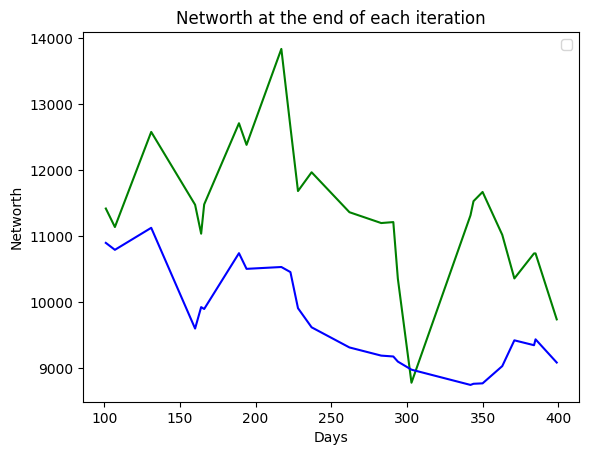

11375.558470916749


Test Parameters for Test 4
{   'Name': 'Test 4',
    'buy_trigger': 2,
    'lockin_gains_factor': 1.1,
    'prefer_beta': False,
    'security_age': 1000,
    'sell_trigger': 1}
Total networth: 11202 (Cash 1970) after going back 101
Model (12.024000)% vs S&P Performance (8.984366)%


Total networth: 11344 (Cash 2490) after going back 107
Model (13.442727)% vs S&P Performance (7.932393)%


Total networth: 10982 (Cash 53) after going back 131
Model (9.821955)% vs S&P Performance (11.266021)%


Total networth: 11162 (Cash 3819) after going back 160
Model (11.621125)% vs S&P Performance (-3.991445)%


Total networth: 11213 (Cash 2933) after going back 164
Model (12.136908)% vs S&P Performance (-0.742743)%


Total networth: 10508 (Cash 1199) after going back 166
Model (5.085145)% vs S&P Performance (-1.026746)%


Total networth: 11630 (Cash 1067) after going back 189
Model (16.306777)% vs S&P Performance (7.423673)%


Total networth: 12347 (Cash 3688) after going back 194
Model (23.478583)% vs S&P Performance (5.050695)%


Total networth: 12213 (Cash 2044) after going back 217
Model (22.136967)% vs S&P Performance (5.330191)%


Total networth: 12218 (Cash 2049) after going back 223
Model (22.188594)% vs S&P Performance (4.560466)%


Total networth: 12478 (Cash 4333) after going back 228
Model (24.783035)% vs S&P Performance (-0.905745)%


Total networth: 11511 (Cash 3744) after going back 237
Model (15.115406)% vs S&P Performance (-3.803326)%


Total networth: 11325 (Cash 2402) after going back 262
Model (13.256140)% vs S&P Performance (-6.853637)%


Total networth: 9035 (Cash 137) after going back 283
Model (-9.642775)% vs S&P Performance (-8.091123)%


Total networth: 11589 (Cash 4115) after going back 291
Model (15.899513)% vs S&P Performance (-8.221883)%


Total networth: 11673 (Cash 2274) after going back 294
Model (16.732765)% vs S&P Performance (-8.996463)%


Total networth: 9941 (Cash 353) after going back 303
Model (-0.586091)% vs S&P Performance (-10.220419)%


Total networth: 8832 (Cash 351) after going back 342
Model (-11.672154)% vs S&P Performance (-12.529905)%


Total networth: 9940 (Cash 23) after going back 344
Model (-0.591307)% vs S&P Performance (-12.356593)%


Total networth: 10976 (Cash 47) after going back 350
Model (9.767292)% vs S&P Performance (-12.292619)%


Total networth: 11061 (Cash 271) after going back 363
Model (10.616440)% vs S&P Performance (-9.681122)%


Total networth: 12474 (Cash 4330) after going back 371
Model (24.747721)% vs S&P Performance (-5.775485)%


Total networth: 10838 (Cash 16) after going back 384
Model (8.389184)% vs S&P Performance (-6.513956)%


Total networth: 10838 (Cash 16) after going back 385
Model (8.389184)% vs S&P Performance (-5.624006)%


Total networth: 10072 (Cash 230) after going back 399
Model (0.723596)% vs S&P Performance (-9.139937)%


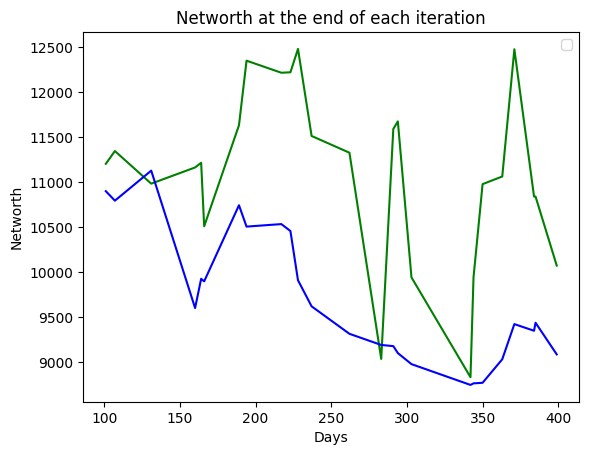

11096.682921409607


Test Parameters for Test 5
{   'Name': 'Test 5',
    'buy_trigger': 2,
    'lockin_gains_factor': 1.1,
    'prefer_beta': True,
    'security_age': 90,
    'sell_trigger': 1}
Total networth: 11418 (Cash 860) after going back 101
Model (14.186547)% vs S&P Performance (8.984366)%


Total networth: 11034 (Cash 966) after going back 107
Model (10.347743)% vs S&P Performance (7.932393)%


Total networth: 12579 (Cash 2566) after going back 131
Model (25.790081)% vs S&P Performance (11.266021)%


Total networth: 10937 (Cash 1167) after going back 160
Model (9.377659)% vs S&P Performance (-3.991445)%


Total networth: 11071 (Cash 1230) after going back 164
Model (10.715045)% vs S&P Performance (-0.742743)%


Total networth: 10906 (Cash 1020) after going back 166
Model (9.063433)% vs S&P Performance (-1.026746)%


Total networth: 12402 (Cash 2667) after going back 189
Model (24.027746)% vs S&P Performance (7.423673)%


Total networth: 12463 (Cash 2585) after going back 194
Model (24.636937)% vs S&P Performance (5.050695)%


Total networth: 13587 (Cash 4450) after going back 217
Model (35.878493)% vs S&P Performance (5.330191)%


Total networth: 12582 (Cash 4620) after going back 223
Model (25.821948)% vs S&P Performance (4.560466)%


Total networth: 11234 (Cash 100) after going back 228
Model (12.342510)% vs S&P Performance (-0.905745)%


Total networth: 10748 (Cash 767) after going back 237
Model (7.485053)% vs S&P Performance (-3.803326)%


Total networth: 11139 (Cash 2475) after going back 262
Model (11.397567)% vs S&P Performance (-6.853637)%


Total networth: 11283 (Cash 164) after going back 283
Model (12.839695)% vs S&P Performance (-8.091123)%


Total networth: 11291 (Cash 53) after going back 291
Model (12.912176)% vs S&P Performance (-8.221883)%


Total networth: 11116 (Cash 1103) after going back 294
Model (11.164651)% vs S&P Performance (-8.996463)%


Total networth: 9456 (Cash 37) after going back 303
Model (-5.436601)% vs S&P Performance (-10.220419)%


Total networth: 10324 (Cash 490) after going back 342
Model (3.245549)% vs S&P Performance (-12.529905)%


Total networth: 11062 (Cash 872) after going back 344
Model (10.628636)% vs S&P Performance (-12.356593)%


Total networth: 13448 (Cash 2612) after going back 350
Model (34.481023)% vs S&P Performance (-12.292619)%


Total networth: 12423 (Cash 4195) after going back 363
Model (24.235594)% vs S&P Performance (-9.681122)%


Total networth: 12346 (Cash 983) after going back 371
Model (23.462001)% vs S&P Performance (-5.775485)%


Total networth: 12651 (Cash 967) after going back 384
Model (26.519039)% vs S&P Performance (-6.513956)%


Total networth: 12651 (Cash 967) after going back 385
Model (26.519039)% vs S&P Performance (-5.624006)%


Total networth: 10407 (Cash 226) after going back 399
Model (4.077095)% vs S&P Performance (-9.139937)%


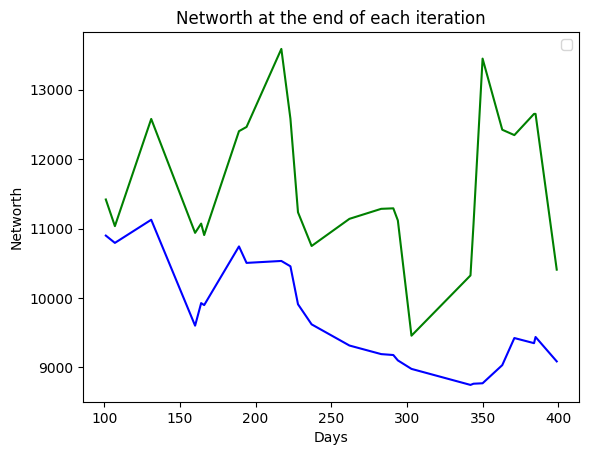

11622.874645233154




In [169]:

for i in tests_to_run:
  t = tests[i-1]
  buy_trigger = t['buy_trigger']    # times standard deviation
  sell_trigger = t['sell_trigger']   # times the avg cost of the security to grow before we sell
  security_age = t['security_age']  # number of days to hold the security before we cut the losses
  lockin_gains_factor = t['lockin_gains_factor'] # times the orignal amount to grow before we lockin the gains.
  prefer_beta = t['prefer_beta']
  print("Test Parameters for " + t['Name'])
  print("=================================")
  pp.pprint(t)
  run_backtest()
  print()
  print("==================================\n")